In [5]:
import torch
import torch.nn
import torchvision

from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt
import os
import random
print(f"torch version : {torch.__version__}")

torch version : 2.0.0


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
image_path = "C:\junha\Personal_Notebook\data"

In [8]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/DutchVandaline/Artificial_Intelligence.git
    !mv Artificial_Intelligence/pytorch_modules .
    !mv Artificial_Intelligence/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from pytorch_modules.pytorch_modules import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [9]:
# Count Image Data length
import os
def walk_through_dir(dir_path):
  """ Walks through dir_path returning its conents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directoreis and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\data'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\data\test'.
There are 0 directoreis and 397 images in 'C:\junha\Personal_Notebook\data\test\defect'.
There are 0 directoreis and 46 images in 'C:\junha\Personal_Notebook\data\test\normal'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\data\train'.
There are 0 directoreis and 1585 images in 'C:\junha\Personal_Notebook\data\train\defect'.
There are 0 directoreis and 182 images in 'C:\junha\Personal_Notebook\data\train\normal'.


In [10]:
augmented_images_dir = "C:\junha\Personal_Notebook\oversampling_data"

In [11]:
walk_through_dir(augmented_images_dir)

There are 3 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data\test'.
There are 0 directoreis and 393 images in 'C:\junha\Personal_Notebook\oversampling_data\test\defect'.
There are 0 directoreis and 353 images in 'C:\junha\Personal_Notebook\oversampling_data\test\normal'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data\train'.
There are 0 directoreis and 1569 images in 'C:\junha\Personal_Notebook\oversampling_data\train\defect'.
There are 0 directoreis and 1409 images in 'C:\junha\Personal_Notebook\oversampling_data\train\normal'.
There are 2 directoreis and 0 images in 'C:\junha\Personal_Notebook\oversampling_data\z_keep_out_for_final_test'.
There are 0 directoreis and 20 images in 'C:\junha\Personal_Notebook\oversampling_data\z_keep_out_for_final_test\defect'.
There are 0 directoreis and 20 images in 'C:\junha\Personal_Notebook\oversamp

In [12]:
oversampling_train_dir = "C:/junha/Personal_Notebook/oversampling_data/train"
oversampling_test_dir = "C:/junha/Personal_Notebook/oversampling_data/test"

In [14]:
efficientNetV2_large_weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT
efficientNetV2 = torchvision.models.efficientnet_v2_l(weights=efficientNetV2_large_weights)
efficientNetV2

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to C:\Users\overr/.cache\torch\hub\checkpoints\efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:40<00:00, 11.6MB/s] 


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

In [15]:
# Get the transforms used to create our pretrained weights
manual_transforms = transforms.Compose([
    transforms.Resize((2532, 824)), # normal은 2532임 defect는 2732
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
manual_transforms

Compose(
    Resize(size=(2532, 824), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [29]:
#Set up dataloaders
from pytorch_modules.pytorch_modules import data_setup
oversampling_train_dataloader, oversampling_test_dataloader, class_names = data_setup.create_dataloaders(train_dir=oversampling_train_dir,
                                                                                                     test_dir=oversampling_test_dir,
                                                                                                     transform=manual_transforms,
                                                                                                     pin_memory=False,
                                                                                                    num_workers=0,
                                                                                                     batch_size=16)
len(class_names)

2

In [30]:
for param in efficientNetV2.features.parameters():
  param.requires_grad = False

In [31]:
efficientNetV2.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=len(class_names))
).to(device)

efficientNetV2.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

In [32]:
# Print with torchinfo
from torchinfo import summary

summary(model = efficientNetV2,
        input_size = (1,3,2532,824), # example of [batch_size, color_channels, height, width]
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
EfficientNet (EfficientNet)                                  [1, 3, 2532, 824] [1, 2]          --              Partial
├─Sequential (features)                                      [1, 3, 2532, 824] [1, 1280, 80, 26] --              False
│    └─Conv2dNormActivation (0)                              [1, 3, 2532, 824] [1, 32, 1266, 412] --              False
│    │    └─Conv2d (0)                                       [1, 3, 2532, 824] [1, 32, 1266, 412] (864)           False
│    │    └─BatchNorm2d (1)                                  [1, 32, 1266, 412] [1, 32, 1266, 412] (64)            False
│    │    └─SiLU (2)                                         [1, 32, 1266, 412] [1, 32, 1266, 412] --              --
│    └─Sequential (1)                                        [1, 32, 1266, 412] [1, 32, 1266, 412] --              False
│    │    └─FusedMBConv (0)                

In [33]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(efficientNetV2.parameters(), lr= 0.001)

In [34]:
torch.cuda.empty_cache()
device

'cuda'

In [35]:
from pytorch_modules.pytorch_modules import engine

from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=efficientNetV2,
                       train_dataloader=oversampling_train_dataloader,
                       test_dataloader =oversampling_test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.2350 | train_acc: 0.9104 | test_loss: 0.0761 | test_acc: 0.9707
Epoch: 2 | train_loss: 0.1255 | train_acc: 0.9502 | test_loss: 0.0538 | test_acc: 0.9747
Epoch: 3 | train_loss: 0.1065 | train_acc: 0.9639 | test_loss: 0.0341 | test_acc: 0.9952
Epoch: 4 | train_loss: 0.0887 | train_acc: 0.9713 | test_loss: 0.0525 | test_acc: 0.9721
Epoch: 5 | train_loss: 0.0885 | train_acc: 0.9693 | test_loss: 0.0148 | test_acc: 1.0000
Epoch: 6 | train_loss: 0.0901 | train_acc: 0.9699 | test_loss: 0.0128 | test_acc: 0.9987
Epoch: 7 | train_loss: 0.0726 | train_acc: 0.9776 | test_loss: 0.0419 | test_acc: 0.9787
Epoch: 8 | train_loss: 0.0580 | train_acc: 0.9803 | test_loss: 0.0121 | test_acc: 0.9987
Epoch: 9 | train_loss: 0.0577 | train_acc: 0.9816 | test_loss: 0.0071 | test_acc: 1.0000
Epoch: 10 | train_loss: 0.0536 | train_acc: 0.9830 | test_loss: 0.0054 | test_acc: 1.0000
[INFO] Total training time:  4642.318 seconds


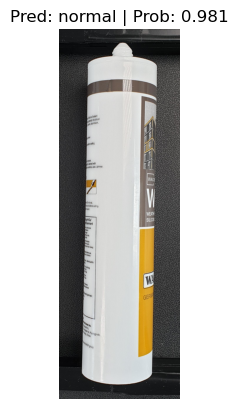

In [36]:
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image
input_image = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/normal/20240823_101759.jpg"

pred_and_plot_image(model=efficientNetV2,
                           image_path=input_image,
                           class_names=class_names,
                            transform=manual_transforms)

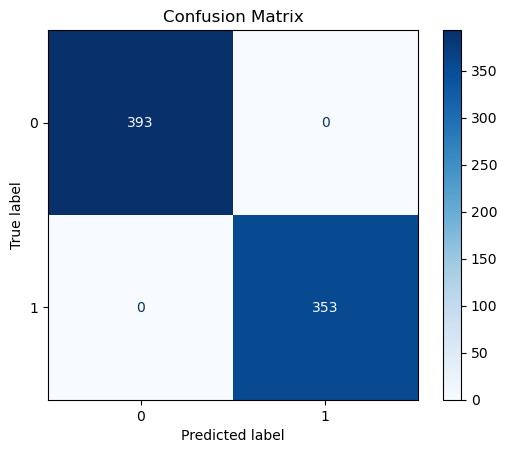

In [37]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Ensure the model is in evaluation mode
efficientNetV2.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Move model to the appropriate device (e.g., CPU or GPU)
efficientNetV2.to(device)

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in oversampling_test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = efficientNetV2(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


F1 Score (Micro): 1.0
F1 Score (Macro): 1.0
Total true labels collected: 746
Total predicted labels collected: 746
True Labels: [1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1

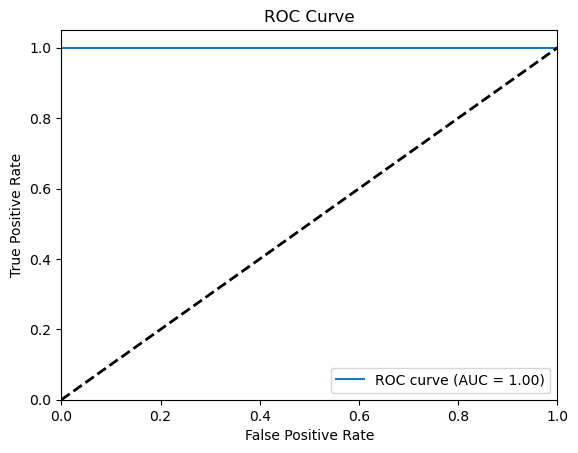

In [38]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, roc_curve, auc
import numpy as np

# Ensure the model is in evaluation mode and move it to the appropriate device
efficientNetV2.to(device)
efficientNetV2.eval()

# Create lists to store true and predicted labels
true_labels = []
predicted_labels = []
all_probabilities = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for data in oversampling_test_dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = efficientNetV2(inputs)
        _, preds = torch.max(outputs, 1)

        # Collect predictions, true labels, and predicted probabilities
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
        all_probabilities.extend(torch.softmax(outputs, dim=1).cpu().numpy())

# Calculate F1 score (micro and macro)
f1_micro = f1_score(true_labels, predicted_labels, average='micro')
f1_macro = f1_score(true_labels, predicted_labels, average='macro')
print(f"F1 Score (Micro): {f1_micro}")
print(f"F1 Score (Macro): {f1_macro}")

# Check if the task is binary classification
if len(np.unique(true_labels)) == 2:
    # Binary classification: Use only one ROC curve
    probabilities_class_1 = np.array(all_probabilities)[:, 1]
    fpr, tpr, thresholds = roc_curve(true_labels, probabilities_class_1)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve for binary classification
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')

# Print total count of true and predicted labels for debugging
print(f"Total true labels collected: {len(true_labels)}")
print(f"Total predicted labels collected: {len(predicted_labels)}")
print(f"True Labels: {true_labels}")
print(f"Predicted Labels: {predicted_labels}")


# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


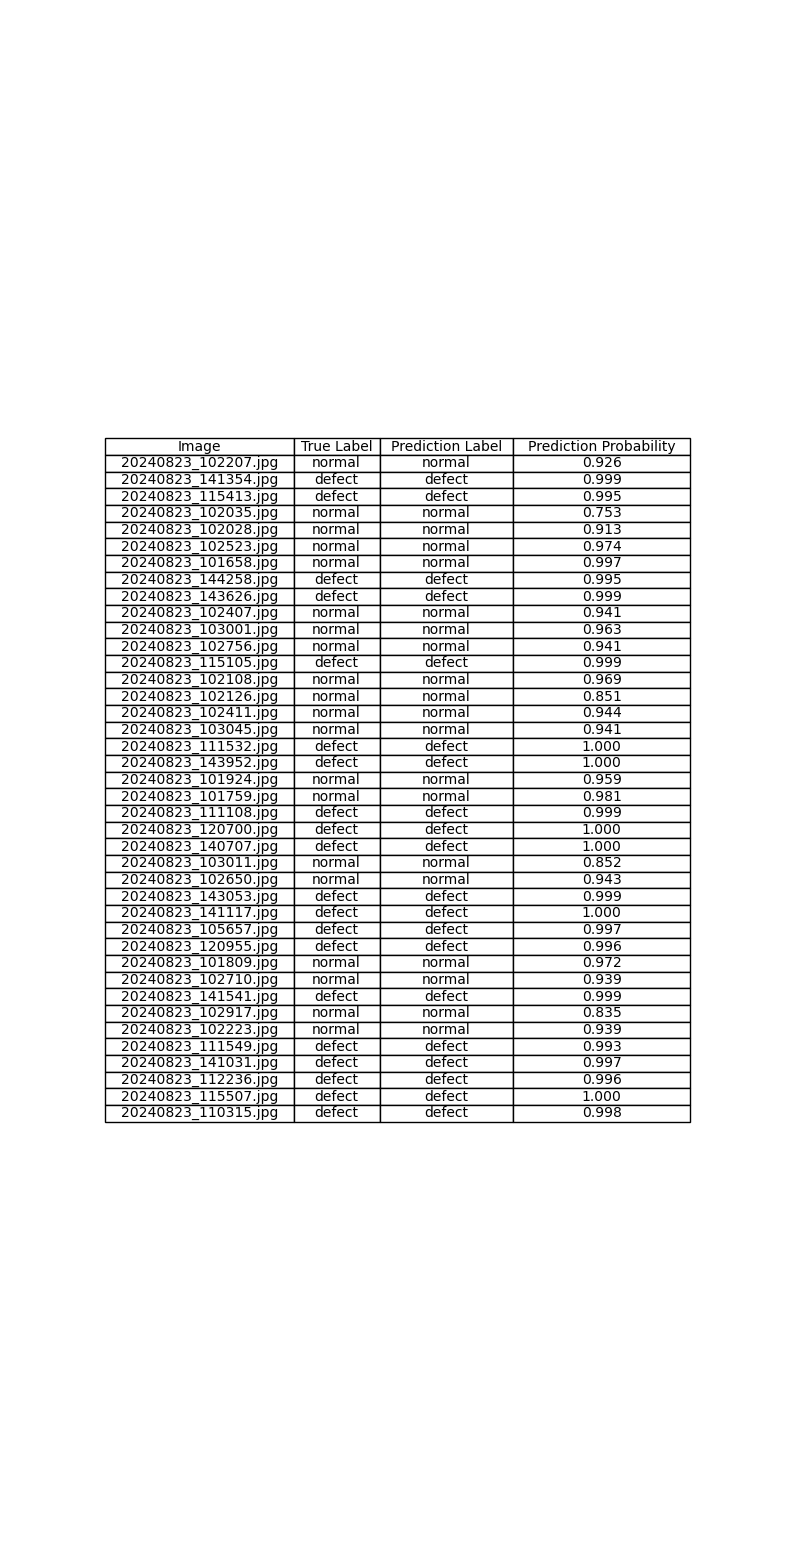

In [39]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
from pytorch_modules.pytorch_modules.predictions import pred_and_plot_image

# Define paths to normal and defect images
normal_folder = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/normal"
defect_folder = "C:/junha/Personal_Notebook/oversampling_data/z_keep_out_for_final_test/defect"

# List all images in normal and defect folders with labels
normal_images = [(os.path.join(normal_folder, img), "normal") for img in os.listdir(normal_folder)]
defect_images = [(os.path.join(defect_folder, img), "defect") for img in os.listdir(defect_folder)]

# Combine and shuffle the images
all_images = normal_images + defect_images
random.shuffle(all_images)

# Initialize list to store predictions
results = []

# Iterate over each image, predict, and store the results
for image_path, true_label in all_images:
    # Predict the label using the model
    pred_and_plot_image(model=efficientNetV2, image_path=image_path, class_names=class_names, transform=manual_transforms)
    
    # Extract the prediction label and probability from the plot title
    plt_title = plt.gca().get_title()  # Get title containing label and probability
    pred_label = plt_title.split('|')[0].split(': ')[1].strip()
    pred_prob = plt_title.split('|')[1].split(': ')[1].strip()  # No conversion, keep the original
    
    # Append results including true label
    results.append([os.path.basename(image_path), true_label, pred_label, pred_prob])
    
    # Close the plot to manage resources
    plt.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Image", "True Label", "Prediction Label", "Prediction Probability"])

# Display results in a table
fig, ax = plt.subplots(figsize=(10, len(results)*0.5))  # Adjust height based on number of rows
ax.axis('off')  # Turn off the axis
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(results_df.columns))))

plt.show()